In [44]:
import psycopg2 as ps
import psycopg2.extras as e
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import itertools as iter

In [15]:

PATH_SPLIT_DATA='/Users/piushagullapalli/Documents/Spring_22/645/Project/seeDb/seeDB/Data/splits'

def split_data(splits):
    data_raw = pd.read_csv(r'/Users/piushagullapalli/Documents/Spring_22/645/Project/seeDb/seeDB/Data/adult.data.txt')
    data_split = np.array_split(data_raw, splits)
    for k in range(1, len(data_split)+1):
        data_split[k-1].to_csv(os.path.join(PATH_SPLIT_DATA ,"split_{}.csv".format(k)),encoding='utf-8', index=False)

split_data(10)

In [131]:
con = ps.connect("dbname='piushagullapalli' user='piushagullapalli' host='localhost' password=''")
curs = con.cursor()

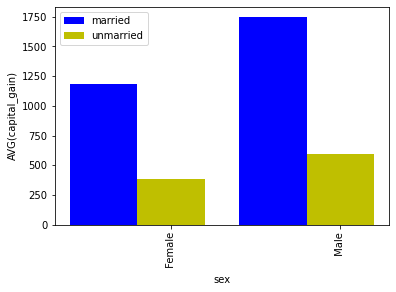

In [109]:
curs.execute("""create or replace view married as 
                   select * from census where marital_status in (' Married-AF-spouse', ' Married-civ-spouse', ' Married-spouse-absent',' Separated');
           create or replace view unmarried as 
                   select * from census where marital_status in (' Never-married', ' Widowed',' Divorced');""")
con.commit()

curs.execute("select sex, avg(capital_gain) from married group by sex;")
target = curs.fetchall()

curs.execute("select sex, avg(capital_gain) from unmarried group by sex;")
reference = curs.fetchall()

def create_plot(afm, reference, target):
    group_attr,function, measure = afm
    plt.subplots()
    graph1 = plt.bar(np.arange(len(target)), target.values(), 0.4, color = 'b', label = 'married')
    graph2 = plt.bar(np.arange(len(target))+0.4, reference.values(), 0.4, color = 'y', label = 'unmarried')
    
    plt.xlabel('{}'.format(group_attr))
    plt.ylabel('{}({})'.format(function, measure))
    plt.xticks(np.arange(len(target))+0.4, target.keys(), rotation=90)
    plt.legend()

    plt.show()

afm_plot = ('sex', 'AVG', 'capital_gain')
create_plot(afm_plot, dict(reference), dict(target))

In [104]:
def normalize(data):
    return data.reshape(-1)

#K-L divergence
def kl_divergence(ref_data, tar_data):
    ref_nor = normalize(ref_data)
    tar_nor = normalize(tar_data)
    pro_ref = [i/np.sum(ref_nor) for i in ref_nor if sum(ref_nor)>0]
    pro_tar = [i/np.sum(tar_nor) for i in tar_nor if sum(tar_nor)>0]
    kl = np.sum([qi  * np.log(qi/pi) for qi, pi in zip(pro_tar, pro_ref) if pi>0 and qi>0])
    return kl

In [40]:
#phased execution

for i in range(10):
    curs.execute("""create or replace view test{}_married as 
                   select * from test{} where marital_status in (' Married-AF-spouse', ' Married-civ-spouse', ' Married-spouse-absent',' Separated');
               create or replace view test{}_unmarried as 
                   select * from test{} where marital_status in (' Never-married', ' Widowed',' Divorced');""".format(i+1,i+1,i+1,i+1))
    con.commit()

In [115]:
group_by_col = ["economic_indicator", "workclass", "occupation", "education", "race", "native_country", "sex", "relationship"]
measure_col = ["capital_loss", "capital_gain", "age", "fnlwgt", "hours_per_week"]

views = {pos:combo for pos, combo in enumerate(list(iter.product(measure_col, group_by_col)))}
print(views)

{0: ('capital_loss', 'economic_indicator'), 1: ('capital_loss', 'workclass'), 2: ('capital_loss', 'occupation'), 3: ('capital_loss', 'education'), 4: ('capital_loss', 'race'), 5: ('capital_loss', 'native_country'), 6: ('capital_loss', 'sex'), 7: ('capital_loss', 'relationship'), 8: ('capital_gain', 'economic_indicator'), 9: ('capital_gain', 'workclass'), 10: ('capital_gain', 'occupation'), 11: ('capital_gain', 'education'), 12: ('capital_gain', 'race'), 13: ('capital_gain', 'native_country'), 14: ('capital_gain', 'sex'), 15: ('capital_gain', 'relationship'), 16: ('age', 'economic_indicator'), 17: ('age', 'workclass'), 18: ('age', 'occupation'), 19: ('age', 'education'), 20: ('age', 'race'), 21: ('age', 'native_country'), 22: ('age', 'sex'), 23: ('age', 'relationship'), 24: ('fnlwgt', 'economic_indicator'), 25: ('fnlwgt', 'workclass'), 26: ('fnlwgt', 'occupation'), 27: ('fnlwgt', 'education'), 28: ('fnlwgt', 'race'), 29: ('fnlwgt', 'native_country'), 30: ('fnlwgt', 'sex'), 31: ('fnlwgt'

In [135]:
def share_based_optimization(tables, views):
    kl_dict={}
    for table in tables:
        for i, (m, a) in views.items():
            query="create or replace view vi_{} as select {}, {}({}),{}({}),{}({}) from {} group by {};".format(table+"_"+str(i),a,"sum",m,"count",m,"avg",m,table,a)
            curs.execute(query)
            con.commit()
            kl_dict[a+"-"+m]=["vi_"+str(table+"_"+str(i))]
    return kl_dict
